<a href="https://colab.research.google.com/github/JianfengMI/MLprojects/blob/main/Quant_KMeans_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 1. Import libriries and globle parameters

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import math
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import statsmodels.api as sm
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

# Reproducibility
RNG = 42
np.random.seed(RNG)

# Parameters
START_DATE = (datetime.today() - timedelta(days=365*6)).strftime("%Y-%m-%d")  # 6y of history
END_DATE = datetime.today().strftime("%Y-%m-%d")
BENCH = "SPY"
MIN_PRICE_HISTORY_DAYS = 252  # at least 1 year
KS = range(2, 11)  # k values to test
REBALANCE_FREQ = "M"  # monthly rebalancing (pandas offset alias)
LOOKBACK_YEARS = 3  # how many years of history for features (used when grabbing prices)
MAX_WEIGHT = 0.10  # cap individual stock weight after momentum weighting (optional)
TRANSACTION_COST_BPS = 5  # basis points per turnover (0.0005 per $1) - set 0 to ignore


## 2. Download SP500 tickers and download the prices

In [ ]:
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status() # Raise an exception for HTTP errors

    # pandas can directly parse tables from HTML content
    tables = pd.read_html(response.text)

    df = None
    # Iterate through found tables to identify the S&P 500 constituents table
    for df_candidate in tables:
        # Check for columns commonly present in the S&P 500 constituents table
        # like 'Symbol', 'Ticker', or 'symbol' (case-insensitive)
        # Convert column names to string before comparison
        cols = [c for c in df_candidate.columns if "Symbol" in str(c) or "Ticker" in str(c) or "symbol" in str(c).lower()]
        if cols:
            df = df_candidate
            break # Found the table

    if df is None:
        raise ValueError("Could not find S&P 500 constituents table on the Wikipedia page.")

    # Ensure 'Symbol' or 'Ticker' column is correctly identified
    # Convert column names to string before comparison
    col_name = [c for c in df.columns if "Symbol" in str(c) or "Ticker" in str(c) or "symbol" in str(c).lower()][0]

    # Clean up ticker symbols (e.g., BRK.B -> BRK-B)
    tickers = df[col_name].astype(str).str.replace(".", "-", regex=False).tolist()
    return tickers

def download_close_prices(tickers, start, end, batch_size=80):
    """
    Download adjusted close prices in batches to avoid yfinance timeouts.
    Returns DataFrame indexed by date with columns=tickers.
    """
    all_close = pd.DataFrame()
    tickers_list = list(tickers) # Use a different variable name to avoid confusion with parameter 'tickers'
    for i in tqdm(range(0, len(tickers_list), batch_size), desc="Downloading prices"):
        batch = tickers_list[i:i+batch_size]
        try:
            data = yf.download(batch, start=start, end=end, progress=False, group_by='ticker', auto_adjust=True)

            if data.empty:
                # If yfinance returns an empty DataFrame, skip this batch.
                print(f"Skipping batch {batch}: No data downloaded.")
                continue

            close_batch = pd.DataFrame()
            # standardized retrieval of 'Close' column
            if isinstance(data.columns, pd.MultiIndex):
                # Correctly extract 'Close' prices from a MultiIndex DataFrame
                # The first level is ticker, second level is metric (Open, High, Low, Close, Volume)
                if 'Close' in data.columns.get_level_values(1):
                    close_batch = data.xs('Close', level=1, axis=1)
                else:
                    print(f"Skipping batch {batch}: 'Close' prices not found for tickers in batch.")
                    continue
            else:
                # This case is less common with group_by='ticker', but if it happens,
                # check if 'Close' is a direct column.
                if 'Close' in data.columns:
                    # Assume it's a single ticker's data, structure as a DataFrame
                    close_batch = pd.DataFrame({batch[0]: data['Close']})
                else:
                    print(f"Skipping batch {batch}: Unexpected data structure without 'Close' column.")
                    continue

            all_close = pd.concat([all_close, close_batch], axis=1)
        except Exception as e:
            print(f"Batch download error for {batch}: {e}")
    # sort columns to requested order, dropping missing tickers
    all_close = all_close.loc[:, all_close.columns.intersection(tickers_list)]
    all_close = all_close.sort_index()
    return all_close

# Fetch tickers and prices
sp500_tickers = get_sp500_tickers()
universe = [t for t in sp500_tickers]  # copy
if BENCH not in universe:
    universe.append(BENCH)

prices = download_close_prices(universe, start=START_DATE, end=END_DATE)
# Remove tickers with insufficient history
valid = [t for t in sp500_tickers if prices.get(t, pd.Series()).dropna().shape[0] >= MIN_PRICE_HISTORY_DAYS]
print(f"{len(valid)} tickers with >= {MIN_PRICE_HISTORY_DAYS} days of data.")

501 tickers with >= 252 days of data.


## 3. Feature engineering function

In [ ]:
def compute_features(close_df, tickers, bench="SPY"):
    """
    Inputs:
      - close_df: DataFrame of adjusted close prices with dates x tickers
      - tickers: list of tickers (subset of close_df.columns)
      - bench: benchmark ticker present in close_df
    Returns:
      - features: DataFrame indexed by ticker (one row per ticker) with required features
    """
    features = pd.DataFrame(index=tickers)
    # return windows (trading days approximations)
    ret_windows = {"ret_1m":21, "ret_3m":63, "ret_6m":126, "ret_12m":252}
    for name, days in ret_windows.items():
        vals = {}
        for t in tickers:
            s = close_df[t].dropna()
            if s.shape[0] >= days + 1:
                vals[t] = (s.iloc[-1] / s.iloc[-days-1]) - 1
            else:
                vals[t] = np.nan
        features[name] = pd.Series(vals)
    # vol (rolling 60d annualized)
    vol_days = 60
    for t in tickers:
        s = close_df[t].dropna()
        if s.shape[0] >= vol_days + 1:
            returns = s.pct_change().dropna()
            # compute latest 60-day std of daily returns
            if returns.shape[0] >= vol_days:
                features.loc[t, "vol_60d_ann"] = returns.rolling(vol_days).std().iloc[-1] * math.sqrt(252)
            else:
                features.loc[t, "vol_60d_ann"] = np.nan
        else:
            features.loc[t, "vol_60d_ann"] = np.nan
    # beta (1y regression vs bench)
    bench_ret = close_df[bench].pct_change().dropna()
    for t in tickers:
        if t == bench:
            features.loc[t, "beta_1y"] = 1.0
            continue
        sret = close_df[t].pct_change().dropna()
        common = sret.index.intersection(bench_ret.index)
        if len(common) > 200:
            Y = sret.loc[common]
            X = sm.add_constant(bench_ret.loc[common])
            try:
                model = sm.OLS(Y, X, missing='drop').fit()
                features.loc[t, "beta_1y"] = model.params[1]
            except Exception:
                features.loc[t, "beta_1y"] = np.nan
        else:
            features.loc[t, "beta_1y"] = np.nan
    # sharpe proxy
    for t in tickers:
        s = close_df[t].dropna()
        if s.shape[0] > 60:
            dret = s.pct_change().dropna()
            ann_mean = dret.mean() * 252
            ann_std = dret.std() * math.sqrt(252)
            features.loc[t, "sharpe_1y"] = ann_mean / (ann_std + 1e-9)
        else:
            features.loc[t, "sharpe_1y"] = np.nan
    # momentum (blend 6m & 3m)
    features["momentum"] = 0.6 * features["ret_6m"] + 0.4 * features["ret_3m"]
    # add simple fundamentals via yfinance info (best-effort; may be slow)
    fund_keys = ["marketCap", "trailingPE", "priceToBook", "earningsQuarterlyGrowth", "revenueQuarterlyGrowth"]
    fund_df = pd.DataFrame(index=tickers, columns=fund_keys)
    for t in tqdm(tickers, desc="Fetching fundamentals (yfinance)"):
        try:
            info = yf.Ticker(t).info
            for k in fund_keys:
                fund_df.loc[t, k] = info.get(k, np.nan)
        except Exception:
            for k in fund_keys:
                fund_df.loc[t, k] = np.nan
    # join and do log transform for marketCap
    features = features.join(fund_df)
    features["log_mktcap"] = np.log(features["marketCap"].replace(0, np.nan).astype(float)) # Convert to float
    # Cleaning: drop tickers with too many NaNs, then median impute
    features = features.dropna(thresh=int(features.shape[1]*0.55))  # keep tickers with at least 55% non-null
    # Drop columns that are entirely NaN *after* row dropping, before median imputation
    # Otherwise, features.median() for such columns will be NaN, and fillna will do nothing.
    features = features.dropna(axis=1, how='all')
    features = features.fillna(features.median())
    return features

# compute features
features = compute_features(prices, valid, bench=BENCH)
features.shape

Fetching fundamentals (yfinance):   0%|          | 0/501 [00:00<?, ?it/s]

(501, 13)

## 4. Clustering helper: run KMeans for k range and choose best k by silhouette

In [ ]:
def run_kmeans_for_range(X_df, ks=range(2,11), random_state=RNG):
    # Ensure no NaNs are passed to KMeans
    X_df = X_df.dropna()
    if X_df.empty:
        return {}, None # Return empty results if no valid data remains

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_df), index=X_df.index, columns=X_df.columns)
    results = {}
    for k in ks:
        km = KMeans(n_clusters=k, n_init=30, random_state=random_state)
        labels = km.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        results[k] = {"model": km, "labels": labels, "silhouette": sil, "calinski": ch, "inertia": km.inertia_}
    return results, X_scaled

# Example run (for full pipeline we'll call inside rebalance loop)
km_results, X_scaled = run_kmeans_for_range(features.select_dtypes(include=[np.number]), ks=KS)

# Check if km_results is empty before processing
if km_results:
    scores_df = pd.DataFrame({k: {"silhouette": km_results[k]["silhouette"], "calinski": km_results[k]["calinski"], "inertia": km_results[k]["inertia"]} for k in km_results}).T
    print(scores_df)
    best_k = max(km_results.keys(), key=lambda kk: km_results[kk]["silhouette"])
    print(f"Best k based on silhouette score: {best_k}")
else:
    print("No valid data to perform clustering. km_results is empty.")
    best_k = None # or handle appropriately if best_k is used later


    silhouette    calinski      inertia
2     0.359679  122.633492  5228.140121
3     0.172137  102.009237  4620.211745
4     0.180783   90.442200  4213.027619
5     0.179393   85.659656  3852.014336
6     0.189825   85.409064  3496.503838
7     0.185930   84.326813  3217.547885
8     0.190738   82.688636  2995.752687
9     0.123264   81.051322  2809.861696
10    0.133320   79.119318  2658.093660
Best k based on silhouette score: 2


Explained Variance Ratio: [0.35458934 0.12912301]


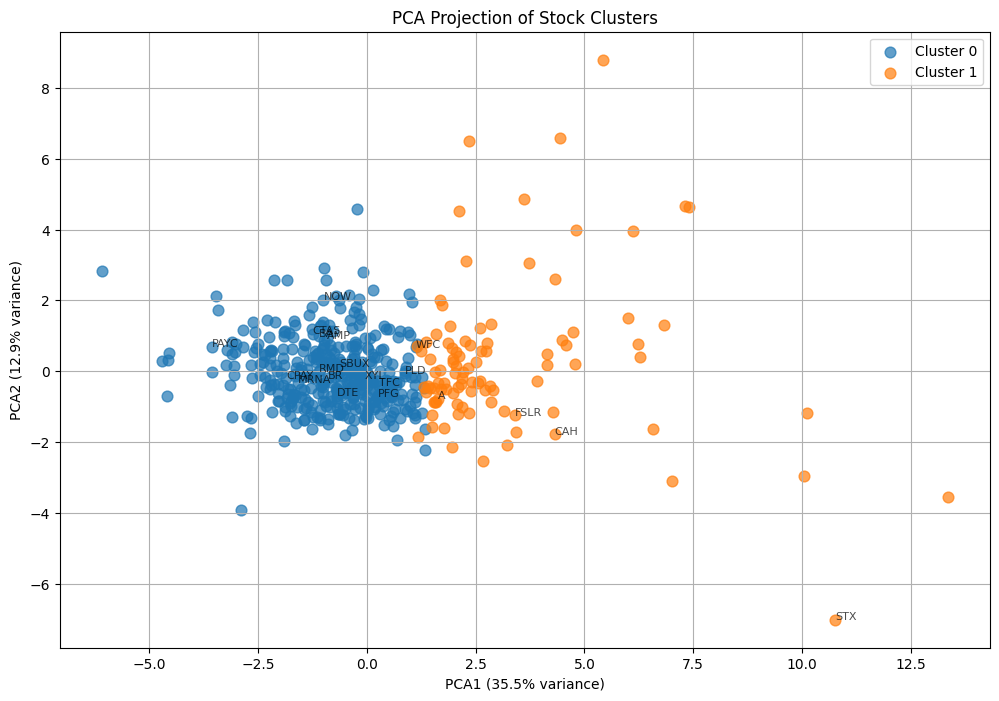

In [ ]:
# PCA on features and plot the clusters with best k

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on scaled feature matrix
scaler = StandardScaler()
df_features_scaled = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_features_scaled)

# Assign cluster labels from the best_k result
cluster_labels = km_results[best_k]["labels"]

# Create a PCA result dataframe
pca_df = pd.DataFrame({
    'PCA1': pca_components[:, 0],
    'PCA2': pca_components[:, 1],
    'Cluster': cluster_labels,
    'Ticker': features.index
})

# Variance explained
expl_var = pca.explained_variance_ratio_
print("Explained Variance Ratio:", expl_var)

# Plot the clusters
plt.figure(figsize=(12, 8))

for cluster in sorted(pca_df['Cluster'].unique()):
    subset = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], s=60, alpha=0.7, label=f'Cluster {cluster}')

# Label a few major stocks to improve readability
for _, row in pca_df.sample(min(20, len(pca_df))).iterrows():
    plt.text(row['PCA1'], row['PCA2'], row['Ticker'], fontsize=8, alpha=0.7)

plt.title("PCA Projection of Stock Clusters")
plt.xlabel(f"PCA1 ({expl_var[0]*100:.1f}% variance)")
plt.ylabel(f"PCA2 ({expl_var[1]*100:.1f}% variance)")
plt.legend()
plt.grid(True)
plt.show()

## 5. Choose best cluster by balanced risk + momentum

In [ ]:
from scipy.stats import zscore

def choose_best_cluster(features_df, labels):
    """
    Compute cluster-level mean metrics and composite score:
      score = z(sharpe_1y) - z(vol_60d_ann) + z(momentum)
    Returns best_cluster (int) and cluster_stats DataFrame
    """
    cluster_series = pd.Series(labels, index=features_df.index, name="cluster")
    df = features_df.join(cluster_series)
    agg = df.groupby("cluster").agg({
        "sharpe_1y": "mean",
        "vol_60d_ann": "mean",
        "momentum": "mean",
        "ret_12m": "mean"
    }).rename(columns={"ret_12m":"avg_12m_ret"})
    # zscore, with handling constant columns
    agg_z = agg.apply(lambda col: zscore(col) if col.std() != 0 else (col - col.mean()))
    agg["score"] = agg_z["sharpe_1y"] - agg_z["vol_60d_ann"] + agg_z["momentum"]
    agg = agg.sort_values("score", ascending=False)
    return int(agg.index[0]), agg

# quick example with best_k
labels = km_results[best_k]["labels"]
best_cluster, cluster_stats = choose_best_cluster(features, labels)
best_cluster, cluster_stats.head()

(1,
          sharpe_1y  vol_60d_ann  momentum  avg_12m_ret  score
 cluster                                                      
 1         0.745877     0.375521  0.345082     0.498814    1.0
 0         0.399179     0.265149 -0.030409    -0.047856   -1.0)

## 6. Momentum-weighted allocation inside cluster (with optional cap)

In [ ]:
def momentum_weights(features_df, tickers, momentum_col="momentum", max_weight=None):
    """
    Produce positive-only momentum weights in tickers list.
    If all momentums <=0, fallback to 12m returns.
    Apply max_weight cap (if provided) and renormalize.
    """
    m = features_df.loc[tickers, momentum_col].copy()
    if (m <= 0).all():
        # fallback to ret_12m
        m = features_df.loc[tickers, "ret_12m"].copy()
    m_pos = m.clip(lower=0) + 1e-9
    raw = m_pos / m_pos.sum()
    if max_weight is not None:
        clipped = raw.clip(upper=max_weight)
        if clipped.sum() == 0:
            # if weird numerical case, revert to raw
            weights = raw
        else:
            weights = clipped / clipped.sum()
    else:
        weights = raw
    return weights.sort_values(ascending=False)

# example
example_weights = momentum_weights(features, [t for t in features.index[:10]], max_weight=MAX_WEIGHT)
example_weights.head()

,momentum
A,0.201965
ABBV,0.201965
AES,0.201965
AMD,0.201965
MMM,0.135686


## 7. Walk-forward backtest (monthly rebalancing)

In [ ]:
def walkforward_backtest(close_prices, features_all, bench="SPY", rebalance_freq="M", ks=range(2,11),
                         lookback=252*1, max_weight=0.10, trans_cost_bps=5):
    """
    close_prices: DataFrame date x tickers (must include bench)
    features_all: precomputed features DataFrame indexed by tickers (useable columns)
    rebalance_freq: pandas offset alias (e.g., 'M' monthly)
    ks: k range for KMeans
    lookback: days used for features (not strictly enforced here; we use features_all which assumes computed)
    returns: DataFrame of portfolio daily returns, weights history, and diagnostics
    """
    # Build rebalancing calendar based on available price dates
    dates = close_prices.index
    # We'll pick the last trading day of each calendar month present in dates
    rebal_dates = dates.to_series().resample(rebalance_freq).last().dropna()
    rebal_dates = rebal_dates[rebal_dates >= (dates[0] + pd.Timedelta(days=60))]  # ensure some history
    rebal_dates = rebal_dates[rebal_dates <= dates[-1]]
    rebal_dates = list(rebal_dates)

    # containers
    daily_portfolio_ret = pd.Series(index=dates, dtype=float).fillna(0.0)
    weights_history = {}
    turnover_history = pd.DataFrame(index=rebal_dates, columns=["turnover", "transaction_cost"])
    prev_weights = pd.Series(dtype=float)

    for i, rb_date in enumerate(tqdm(rebal_dates, desc="Rebalance loop")):
        # Use information up to rb_date (we already computed features_all from full history; in production recompute features using only up-to-date data)
        # Subset tickers available at rb_date
        available = [t for t in features_all.index if (t in close_prices.columns) and (not np.isnan(close_prices.loc[:rb_date, t]).all())]
        if len(available) < 10:
            continue

        # prepare features subset and run clustering on numeric features
        fsub = features_all.loc[available].select_dtypes(include=[np.number])
        km_results, X_scaled = run_kmeans_for_range(fsub, ks=ks, random_state=RNG)
        best_k = max(km_results.keys(), key=lambda kk: km_results[kk]["silhouette"])
        labels = km_results[best_k]["labels"]
        best_cluster, cluster_stats = choose_best_cluster(fsub, labels)
        # select tickers in best cluster
        cluster_series = pd.Series(labels, index=fsub.index, name="cluster")
        selected = cluster_series[cluster_series == best_cluster].index.tolist()
        if len(selected) == 0:
            continue

        # compute momentum weights and apply cap
        w = momentum_weights(features_all, selected, momentum_col="momentum", max_weight=max_weight)
        # store weights for this rebalance date
        weights_history[rb_date] = w

        # compute daily returns from rb_date (inclusive) to next rebalance date (exclusive)
        start_idx = close_prices.index.get_loc(rb_date)
        if i+1 < len(rebal_dates):
            next_rb = rebal_dates[i+1]
            end_idx = close_prices.index.get_loc(next_rb)  # exclusive
            period_dates = close_prices.index[start_idx:end_idx]
        else:
            period_dates = close_prices.index[start_idx:]
        # compute daily returns for selected tickers
        sub = close_prices[selected].loc[period_dates]
        ret = sub.pct_change().fillna(0)
        # apply portfolio weights: for first day, use weights w; assume static until next rebalance
        # portfolio daily return = sum(weights * tickers daily return)
        weights_array = w.reindex(selected).fillna(0).values
        p_ret = (ret.fillna(0) * weights_array).sum(axis=1)
        daily_portfolio_ret.loc[period_dates] = p_ret.values

        # turnover: compare prev_weights to new w on the rebalance date
        if prev_weights.size > 0:
            # align prev and current, fill zeros
            prev = prev_weights.reindex(w.index).fillna(0)
            curr = w.reindex(prev.index).fillna(0)
            turnover = (prev - curr).abs().sum() / 2.0
        else:
            turnover = w.abs().sum()  # initial full buy
        transaction_cost = turnover * (trans_cost_bps/10000.0)
        turnover_history.loc[rb_date] = [turnover, transaction_cost]
        prev_weights = w.copy()

    # create portfolio returns series
    port_ret = daily_portfolio_ret.fillna(0)
    bench_ret = close_prices[bench].pct_change().fillna(0).reindex(port_ret.index).fillna(0)

    # subtract transaction cost at rebalance days (apply as a negative return on the rebalance date)
    for d, row in turnover_history.dropna().iterrows():
        tc = float(row["transaction_cost"])
        if d in port_ret.index:
            port_ret.loc[d] = port_ret.loc[d] - tc

    # aggregate outputs
    weights_df = pd.DataFrame({d: weights_history[d] for d in weights_history}).T.fillna(0).sort_index()
    return port_ret, bench_ret, weights_df, turnover_history

# Run the walkforward backtest (this may take several minutes due to yfinance fundamentals + clustering per rebalance)
port_ret, bench_ret, weights_df, turnover_history = walkforward_backtest(prices, features, bench=BENCH,
                                                                         rebalance_freq=REBALANCE_FREQ, ks=KS,
                                                                         lookback=252*1, max_weight=MAX_WEIGHT,
                                                                         trans_cost_bps=TRANSACTION_COST_BPS)


Rebalance loop:   0%|          | 0/71 [00:00<?, ?it/s]

## 8. Performance metrics & helper functions

In [ ]:
def performance_table(returns, freq=252):
    """
    returns: pd.Series of daily returns
    freq: trading days per year
    """
    ann_ret = (1 + returns).prod() ** (freq / len(returns)) - 1
    ann_vol = returns.std() * math.sqrt(freq)
    sharpe = ann_ret / (ann_vol + 1e-9)
    cum = (1 + returns).cumprod() - 1
    peak = cum.cummax()
    drawdown = (cum - peak)
    max_drawdown = drawdown.min()
    return {"CAGR": ann_ret, "AnnVol": ann_vol, "Sharpe": sharpe, "MaxDrawdown": max_drawdown, "TotalReturn": cum.iloc[-1]}

def compute_drawdown(returns):
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1
    return dd

# compute metrics
perf_port = performance_table(port_ret.dropna())
perf_bench = performance_table(bench_ret.dropna())

print("Portfolio performance:", perf_port)
print("Benchmark performance:", perf_bench)


Portfolio performance: {'CAGR': np.float64(0.29994917574860613), 'AnnVol': 0.260033441595135, 'Sharpe': np.float64(1.1535023062999588), 'MaxDrawdown': -0.8334794331603192, 'TotalReturn': np.float64(3.7956304069040883)}
Benchmark performance: {'CAGR': np.float64(0.15204248373296214), 'AnnVol': 0.20727227749422553, 'Sharpe': np.float64(0.733539886942469), 'MaxDrawdown': -0.40070127003789824, 'TotalReturn': np.float64(1.3299544633747633)}


## 9. Charts: cumulative returns, drawdown, rolling volatility

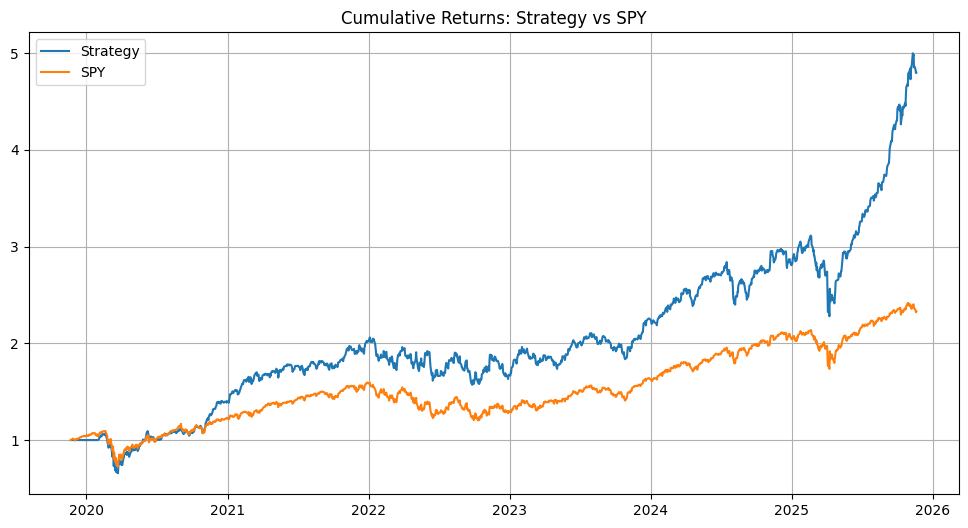

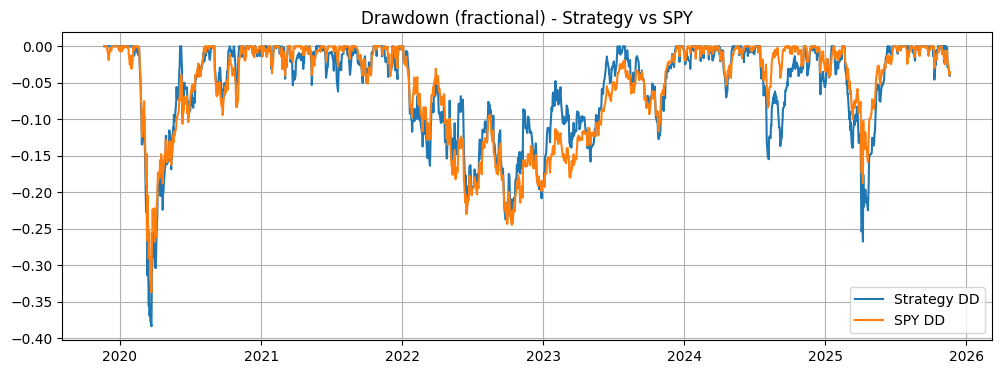

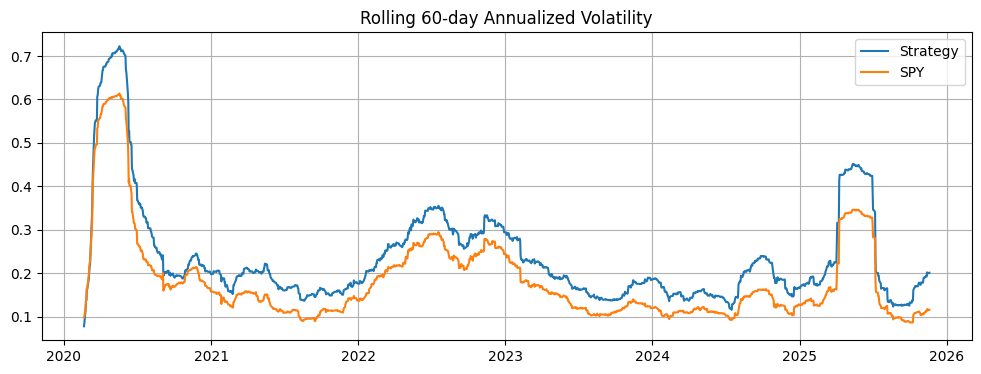

In [ ]:
# cumulative returns
cum_port = (1 + port_ret).cumprod()
cum_bench = (1 + bench_ret).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cum_port.index, cum_port.values)
plt.plot(cum_bench.index, cum_bench.values)
plt.title("Cumulative Returns: Strategy vs SPY")
plt.legend(["Strategy", "SPY"])
plt.grid(True)
plt.show()

# drawdown
dd_port = compute_drawdown(port_ret)
dd_bench = compute_drawdown(bench_ret)

plt.figure(figsize=(12,4))
plt.plot(dd_port.index, dd_port.values)
plt.plot(dd_bench.index, dd_bench.values)
plt.title("Drawdown (fractional) - Strategy vs SPY")
plt.legend(["Strategy DD", "SPY DD"])
plt.grid(True)
plt.show()

# rolling annualized volatility (60-day)
roll_vol_port = port_ret.rolling(window=60).std() * math.sqrt(252)
roll_vol_bench = bench_ret.rolling(window=60).std() * math.sqrt(252)

plt.figure(figsize=(12,4))
plt.plot(roll_vol_port.index, roll_vol_port.values)
plt.plot(roll_vol_bench.index, roll_vol_bench.values)
plt.title("Rolling 60-day Annualized Volatility")
plt.legend(["Strategy", "SPY"])
plt.grid(True)
plt.show()


## 10. Inspect weights & turnover

Latest top weights:


,2025-11-19
WDC,0.050216
WBD,0.039767
MU,0.035410
STX,0.034718
ALB,0.029345
TER,0.026540
AMD,0.021975
LRCX,0.020380
GOOGL,0.018669
GOOG,0.018350


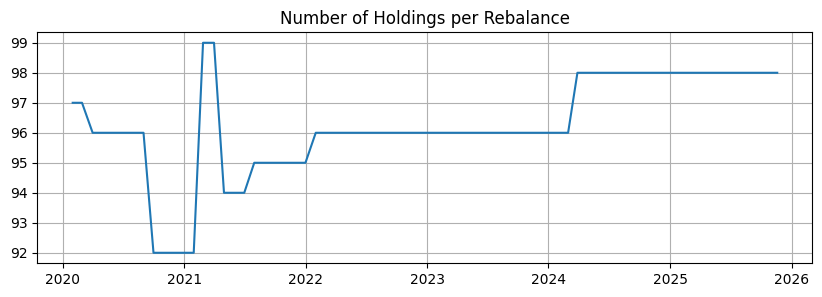

,turnover,transaction_cost
2020-01-31,1.0,0.0005
2020-02-28,0.0,0.0
2020-03-31,0.001839,0.000001
2020-04-30,0.0,0.0
2020-05-29,0.0,0.0
2020-06-30,0.0,0.0
2020-07-31,0.0,0.0
2020-08-31,0.0,0.0
2020-09-30,0.01495,0.000007
2020-10-30,0.0,0.0


In [ ]:
# Show the most recent weights
if not weights_df.empty:
    latest_weights = weights_df.iloc[-1].sort_values(ascending=False).head(20)
    print("Latest top weights:")
    display(latest_weights)
else:
    print("No weights computed.")

# Plot number of holdings per rebalance
num_holdings = (weights_df > 0).sum(axis=1)
plt.figure(figsize=(10,3))
plt.plot(num_holdings.index, num_holdings.values)
plt.title("Number of Holdings per Rebalance")
plt.grid(True)
plt.show()

# Turnover summary
if not turnover_history.dropna().empty:
    display(turnover_history.dropna().head(10))
